# Library Initialization

In [3]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import xgboost as xgb
from sklearn.model_selection import train_test_split
import empyrical
from pypfopt.efficient_frontier import EfficientFrontier
from sklearn import linear_model


# Data Imports

In [7]:
tickers = ["GE", "PFE","SBUX", "GME", "DAL", "AAPL", "GOOGL" ]
stocks = pd.concat([yf.Ticker(i).history(period = "max")["Close"].pct_change().dropna().rename(i) for i in tickers], axis=1, join = 'inner')


In [81]:
days = 5
weeks = 2
#Means

X1 = stocks.resample(str(days)+"d").mean()
X2 = stocks.resample(str(days)+"d").mean().shift(1).dropna()
Y = stocks.resample(str(days)+"d").mean().shift(2).dropna()
X2 = X2.iloc[:-1]
X1 = X1.iloc[:-2]
X1 = np.vstack((X1[col].values.reshape(-1,1) for col in X1.columns))
X2 = np.vstack((X2[col].values.reshape(-1,1) for col in X2.columns))
X = np.hstack((X1, X2))
Y = np.vstack((Y[col].values.reshape(-1,1) for col in Y.columns)).flatten()
#Covar


<ipython-input-81-148cabd8c903>:10: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X1 = np.vstack((X1[col].values.reshape(-1,1) for col in X1.columns))
<ipython-input-81-148cabd8c903>:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X2 = np.vstack((X2[col].values.reshape(-1,1) for col in X2.columns))
<ipython-input-81-148cabd8c903>:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Y = np.vstack((Y[col].values.reshape(-1,1) for col in Y.columns)).flatten()


In [87]:
X.shape

(7133, 2)

In [22]:
Y

,GE,PFE,SBUX,GME,DAL,AAPL,GOOGL
Date,,,,,,,
2007-05-09,-0.002321,0.005933,-0.015366,-0.001272,-0.017619,0.015301,-0.004538
2007-05-14,-0.000954,-0.000201,-0.006305,-0.008208,-0.005567,0.011557,0.000022
2007-05-19,-0.000021,0.002952,-0.004377,0.017555,0.000449,0.002413,0.001647
2007-05-24,0.005740,-0.001216,-0.000653,0.003165,-0.001550,0.008674,0.002600
2007-05-29,-0.000518,0.003485,-0.004740,-0.000690,-0.011780,0.003491,0.010067
...,...,...,...,...,...,...,...
2021-03-31,0.011614,0.004180,0.009065,0.019759,0.013361,-0.001883,0.002310
2021-04-05,-0.000679,0.002628,-0.004031,-0.007637,-0.000644,0.012862,0.020227
2021-04-10,0.004797,0.001683,0.006889,-0.037044,0.002051,0.015783,0.013012


# Mean-Variance Optimization Function

In [148]:
days = 5
X_sample = stocks.resample(str(days)+"d").mean()
dates = X_sample.index[1:-1]
portfolio = pd.DataFrame()

saved_weights = []
r0s = []

for day in dates[2:]: 
    sample_1 = stocks[day-pd.offsets.DateOffset(days = 2*days):day-pd.offsets.DateOffset(days=days-1)]
    sample_2 = stocks[day-pd.offsets.DateOffset(days = days):day-pd.offsets.DateOffset(days=1)]
    X1 = sample_1.mean().values.reshape(-1,1)
    X2 = sample_2.mean().values.reshape(-1,1)
    X_data = np.hstack((X1, X2))
    #sample = stocks[day+pd.offsets.DateOffset(days = 7):day+pd.offsets.DateOffset(days=13)]
    #Using Previous Data:
    #mean = sample.mean(axis=0)
    mean = pd.Series(model.predict(X_data), index = sample.columns)
    covar = sample.cov()
    
    
    weights_vector = [EfficientFrontier(mean,covar).max_quadratic_utility()[ticker] for ticker in stocks.columns]
    portfolio = pd.concat([portfolio,stocks[day:day+pd.offsets.DateOffset(days=days-1)].dot(weights_vector)])
    saved_weights.append(weights_vector)
portfolio = portfolio.sort_index()
saved_weights = pd.DataFrame(saved_weights, index = dates[2:], columns = tickers)

In [149]:
empyrical.sharpe_ratio(portfolio)

array([0.60327042])

# Ridge CV Regression Model

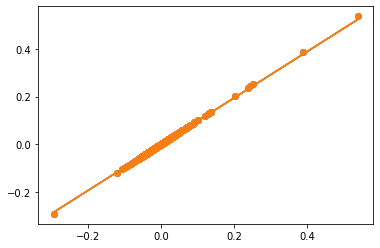

In [89]:
model = linear_model.RidgeCV()
model.fit(X, Y)
y_pred = model.predict(X)
plt.plot(X, y_pred)
plt.scatter(X[:,0], Y)
plt.scatter(X[:,0], Y)